# Boston consulting group modified matrix

**Цель проекта:** Построение модифицированной матрицы Бостонской консалтинговой группы (БКГ) на основе вторичной информации об динамике продаж товарных групп с использованием регрессионного моделирования.

**Входные данные:** Динамика продаж в разрезе товарных групп.

**Выходные данные:**
Статус товарных групп - знаки вопроса, звёзды, дойные коровы, собаки (в соответствии с квадрантами матрицы).

**Выходные данные для бизнеса:**

Информация, на основе которой ЛПР может принять решение о том, какие товары (подразделения, ассортиментные группы) стоит развивать и беречь, а какие следует ликвидировать.

**Теоретическая сводка:** В отличие от классической матрицы БКГ, координатами которой являются *темп роста рынка* и *относительная доля рынка*, которые сложно определить на практике, модифицированная матрица БКГ будет строиться на их аналогах, рассчитываемых на основе трендов в форме моделей робастной линейной регрессии:


Аналог относительной доли рынка $k_i$$=Y_i/Y_0*100$%, где:
- $k_i$ - удельный вес товарной группы в общем объёме сбыта за период;
- $Y_i$ - объём сбыта i-ой товарной группы в денежном выражении за период; 
- $Y_0$ - суммарный объём сбыта в денежном выражении за период.


Аналог темпа роста рынка $t_i$$=a_i/a_0*100$%, где:
- $t_i$ - удельный вес товарной группы в темпе изменения объёмов сбыта;
- $a_i$ - коэффициент тренда i-ой товарной группы за период;
- $a_0$ - коэффициент тренда суммарного объёма сбыта за период.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [96]:
sales = pd.read_csv('БКГ.txt', sep = '\t')

# Приведение исходных данных к необходимому виду
products = sales.iloc[:-1,1:-1]
products

,ЭХОЛОТЫ,НАВИГАТОРЫ,КАМЕРЫ
0,57810,119150,5550
1,62115,249710,5434
2,66930,302800,5345
3,78075,408400,4879
4,79356,486060,5008
5,87594,567845,4675
6,89587,678980,4356
7,92876,789456,4367
8,94786,879678,4235
9,98786,947348,4175


In [91]:
class BCGmatrix():
    
    def __init__(self, products):
        
        self.groups = {}
        for column in products.columns:
            self.groups[f'{column}'] = products[column]

            
        self.total = np.array([0]*(len(products)))
        for group in self.groups.keys():
            self.total += self.groups[group]
        self.total = self.total.rename('Total')
            
        self.sums = {}
        for group in self.groups:
            self.sums[f'{group}'] = sum(self.groups[f'{group}'])
        self.sums['total'] = (sum(self.total))
        
    def robust_regression(self, learning_rate=3, iterations=10000, target=0):
        """ Запускает процесс оптимизации весов линейной регрессии
        на основе градиентного спуска с шагом спуска learning_rate,
        и количеством шагов iterations.
        Возвращает трендовые модели.
        """
        y = np.array(target)
        periods = np.arange(1,len(y)+1).reshape(10,1)
        bias = np.ones(shape = (len(periods), 1))
        predictors = np.concatenate([periods, bias], axis = 1)
        weights = np.random.uniform(size=predictors.shape[1])
        learning_rate = learning_rate
        num_steps = 0
        errors = []

        while num_steps < iterations:
            num_steps +=1
            gradient = np.sum(predictors * (np.sign(predictors.dot(weights) - y)).reshape(len(predictors),1) / len(predictors), axis=0)
            weights -= learning_rate*gradient
            MAE = np.sum(np.abs(y - weights@predictors.T))/len(predictors)
            errors.append([MAE, num_steps, weights])
            
        plt.plot(periods, min(errors)[2]@predictors.T, label=f'Robust linear trend for {target.name}')
        plt.scatter(periods, y);
        plt.legend()
        
        return weights
                              
    def compute_statistics(self, learning_rate=3, iterations=10000):
        ''' Рассчитывает координаты товарных групп для модифицированной матрицы БКГ. '''
        
        t = {}
        
        for key in self.groups.keys():
            t[f'{key}'] = self.robust_regression(learning_rate,
                                                 iterations,
                                                 target=self.groups[f'{key}'])[0] 
            
        t_total = self.robust_regression(learning_rate,
                                         iterations,
                                         target=self.total)[0]
        
        t_i = np.array(list(t.values()))
        t_i = t_i/t_total*100
        k_i = []
        for i in range(len(self.sums)):
            k = np.array(list(self.sums.values()))[i]/self.sums['total']*100
            if i < len(self.sums)-1:
                k_i.append(k)
            else:
                break
        res = {}
        for i, key in enumerate(self.groups.keys()):
            res[f'{key}'] = [t_i[i], k_i[i]]
        
        return k_i, t_i, res
    
    def fit(self, learning_rate=3, iterations=10000):
        """ Строит матрицу БКГ и классифицирует товарные группы по типам. """
        k_i, t_i, res = self.compute_statistics(learning_rate, iterations);
        plt.show()
        
        fig, ax = plt.subplots()
    
        
        for k, t in zip(k_i, t_i):
            if k < 25 and t < 25:
                ax.scatter(k, t, color='red', marker='_')
            elif k < 25 and t > 25:
                ax.scatter(k, t, color='blue', marker='$?$')
            elif k > 25 and t > 25:
                ax.scatter(k, t, color='orange', marker = '*')
            else:
                ax.scatter(k, t, color='green', marker = '+')

        ax.grid()
        
        ax.vlines(25, 0, 100, color='black')
        ax.hlines(25, 0, 100, color='black')

        plt.xlabel('Market share, %')
        plt.ylabel('Market growth rate, %')
        plt.title('BCG Matrix')
        plt.show()
        
        results = {}
        dogs = []
        stars = []
        questions = []
        cows = []
        
        for k in res.keys():
            if res[k][0] < 25 and res[k][1] < 25:
                dogs.append(k)
            elif res[k][0] > 25 and res[k][1] > 25:
                stars.append(k)
            elif res[k][0] > 25 and res[k][1] < 25:
                cows.append(k)
            else:
                questions.append(k)
        results['Cows'] = cows
        results['Dogs'] = dogs
        results['Stars'] = stars
        results['Questions'] = questions
        return results

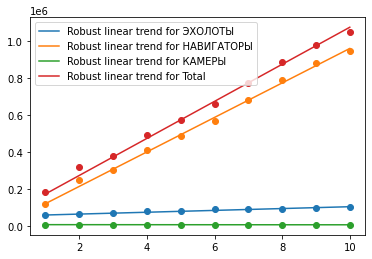

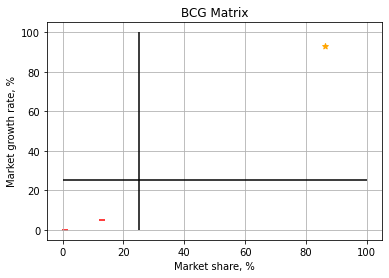

{'Cows': [],
 'Dogs': ['ЭХОЛОТЫ', 'КАМЕРЫ'],
 'Stars': ['НАВИГАТОРЫ'],
 'Questions': []}

In [95]:
BCGmatrix(products).fit(learning_rate=20, iterations=10000)